### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! All four have been imported for you in this Notebook.**

In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
import random
import sys

### Data loading

Train and Test sets can be found in the `Resources` folder. You can choose to visualize your data all at once, in windows, or only considering a subset of sensors to detect which ones would prove most useful to your analysis.
An example of such a visualization can be found in the following cell.

In [2]:
train_file_path = 'lab1_train.csv'

train_data = pd.read_csv(train_file_path, delimiter=',')

# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

test_file_path = 'lab1_test.csv'

test_data = pd.read_csv(test_file_path, delimiter=',')

# Convert Timestamp column to datetime
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

# Familiarization

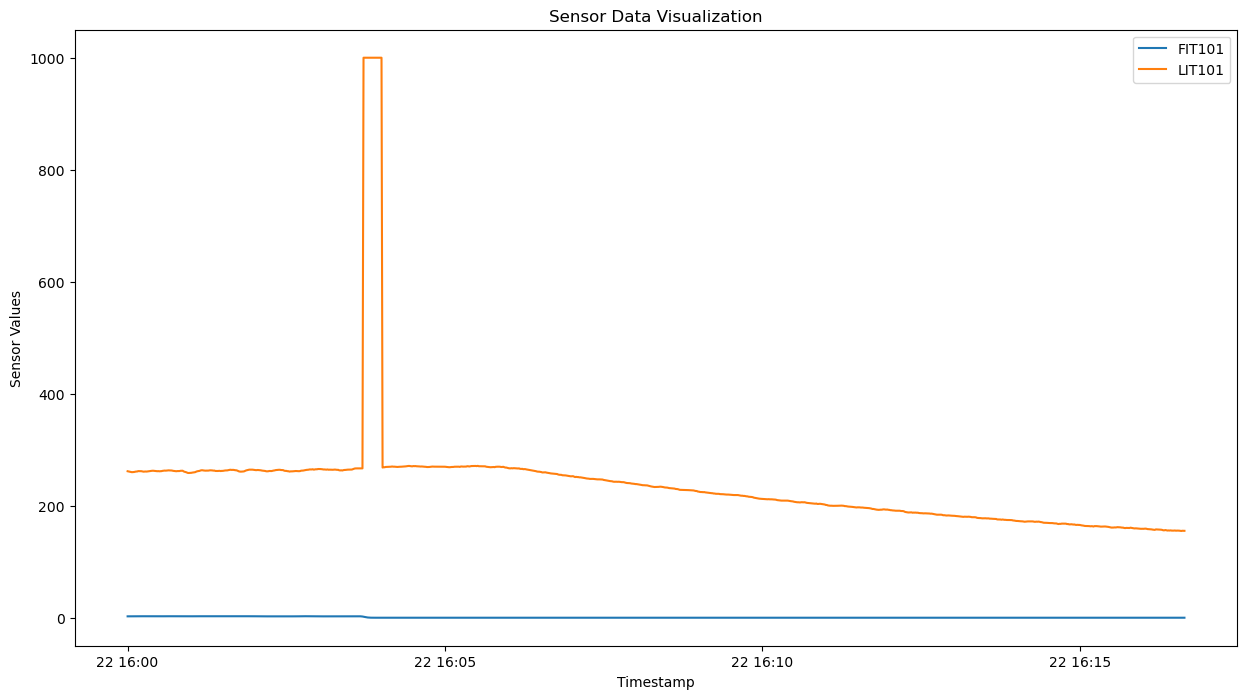

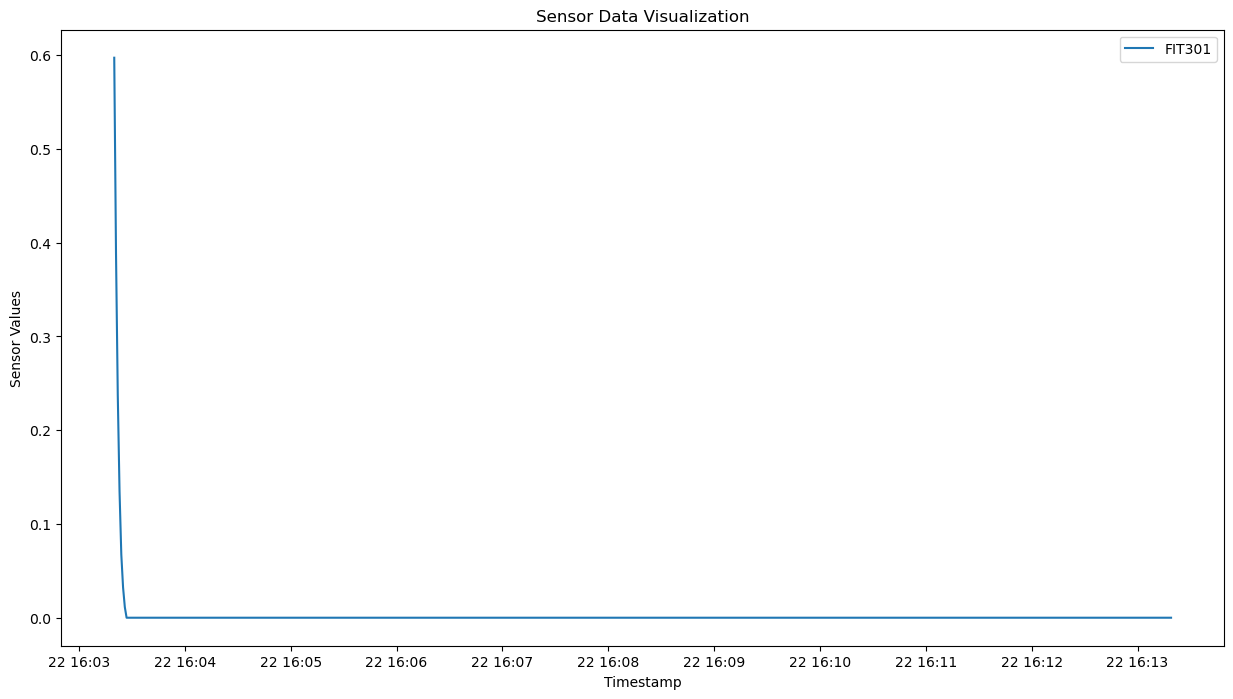

/Users/diwu/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


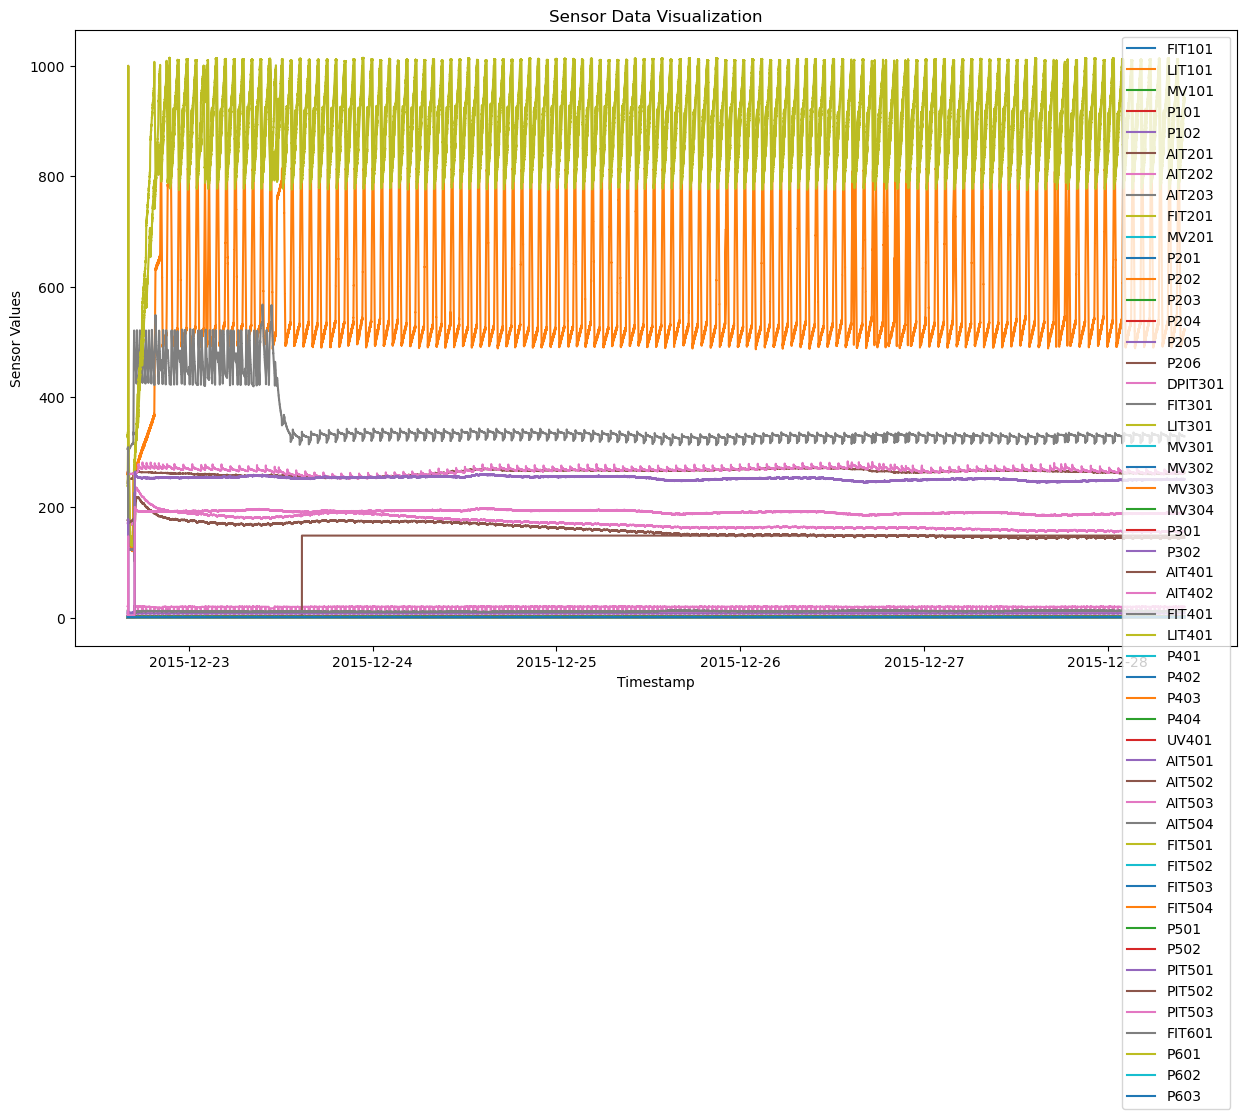

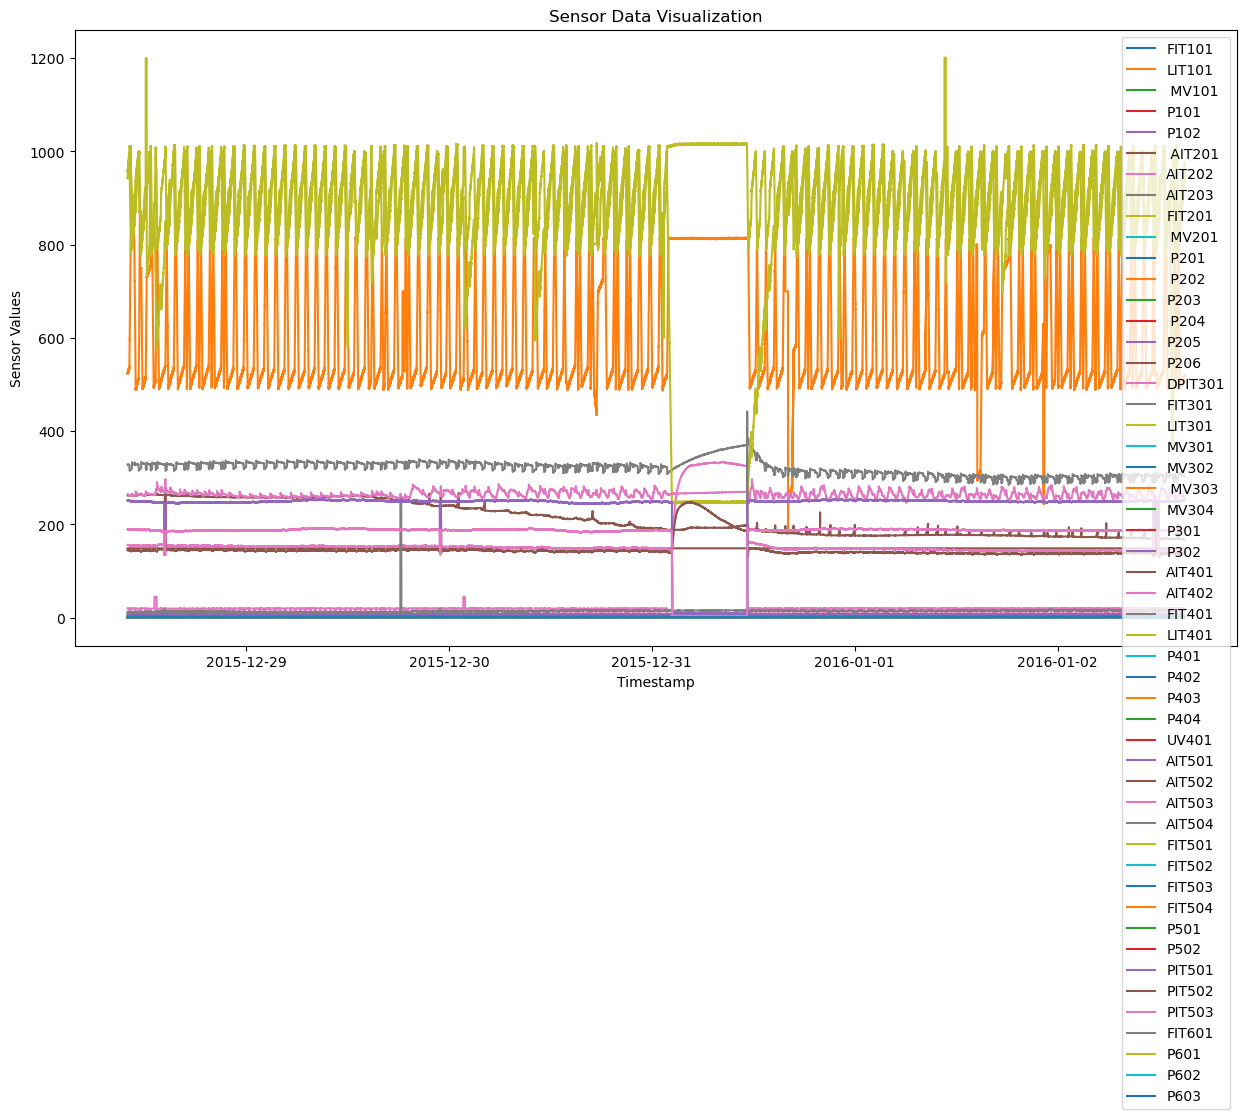

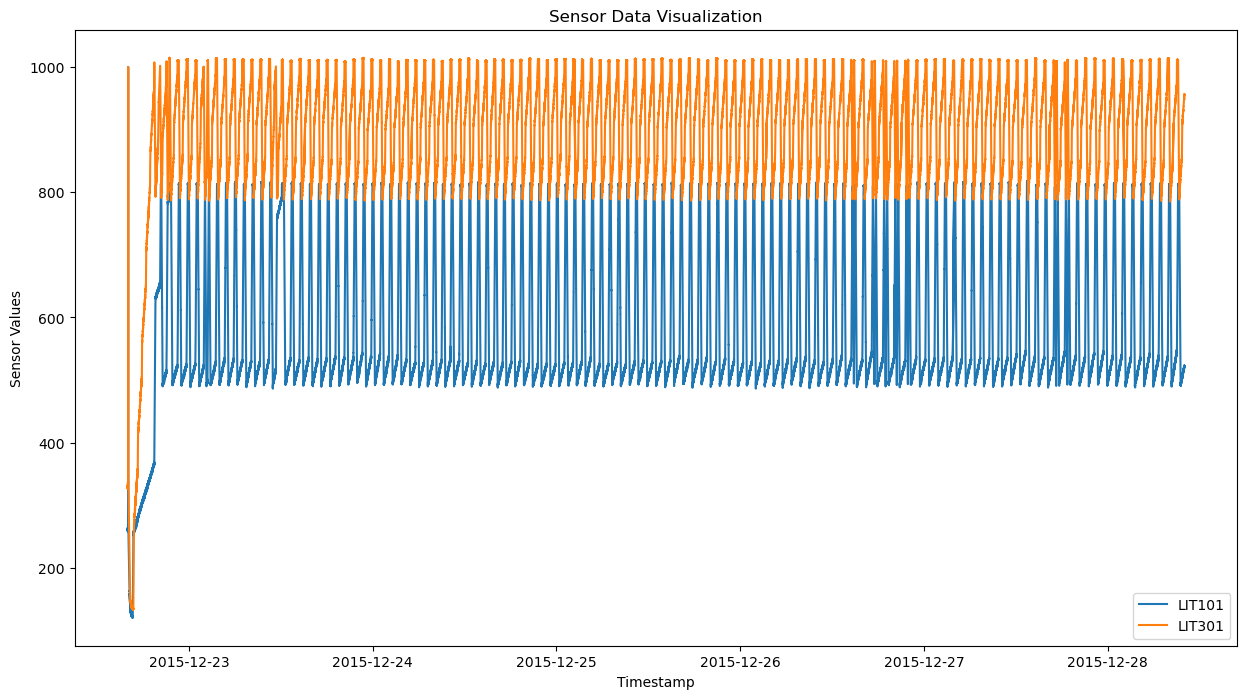

In [3]:
def visualize_sensor_data(df, window=None, sensors=None):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    plt.legend()

    plt.show()

visualize_sensor_data(train_data, window=(0, 1000), sensors=['FIT101', 'LIT101'])
visualize_sensor_data(train_data, window=(200, 800), sensors=['FIT301'])
visualize_sensor_data(train_data)
visualize_sensor_data(test_data)
visualize_sensor_data(train_data, sensors=['LIT101','LIT301'])

1. All the sensor data are discrete signals, even though the data points represent values for each second, they should still be considered discrete signals since the values are defined at specific discrete time points (seconds). There are some analog signals, which are transmitted in waves. There are also digital signals, transmitted with discrete values like 1s and 0s. We also seem to have periodic type data, like sensor LIT301, it seems very periodic after the start. 

2. Some of the signals are correlated, such as 'LIT101' and 'LIT301'. The signals get more dense when the others also get more dense, which means they have similar periods. They also do show partial cyclic behaviour. 

# DTW-based anomaly detection
Fast DTW might not give the optimal distance between 2 windows but it goes extremely fast when we have a big window size, making the time complexity from quadratic to linear. 
### Design Pattern of Fast DTW
It starts from the top left slot of the distance matrix and directly chooses the minimum path from the right, bottom, or bottom right slot. We choose the bottom right path if there is a tie since it is closer to the destination, which makes this algorithm even faster. 

In [4]:
import numpy as np

def dynamic_time_warping(a, b):
    n = a.size
    m = b.size
    
    # Option 1: Fast DTW
    row = 0
    column = 0
    dtw_distance = (a[0] - b[0])**2
    while row < n-1 and column < m-1:
        right = (a[row] - b[column+1])**2
        bottom = (a[row+1] - b[column])**2
        bottom_right = (a[row+1] - b[column+1])**2
        min_dist = min(right, bottom, bottom_right)
        if min_dist == bottom_right:
            row+=1
            column+=1
        elif min_dist == right:
            column+=1
        else:
            row+=1
        dtw_distance += min_dist
    while column<m-1:
        column+=1
        dtw_distance += (a[row] - b[column])**2
    while row<n-1:
        row+=1
        dtw_distance +=(a[row] - b[column])**2
    dtw_distance = np.sqrt(dtw_distance)

    # Option 2: the Optimal DTW distance (weblab)
    # dp = np.zeros((n, m)) + np.inf
    # dp[0,0] = (a[0] - b[0])**2
    # for i in range(1,n):
    #     dp[i,0] = (a[i]-b[0])**2 + dp[i-1,0]
    # for j in range(1,m):
    #     dp[0,j] = (a[0]-b[j])**2 + dp[0,j-1] 
    # for i in range(1,n):
    #     for j in range(1,m):
    #         dp[i, j] = (a[i]-b[j])**2 + min(dp[i-1, j], dp[i, j-1], dp[i-1, j-1])
    # dtw_distance = np.sqrt(dp[n-1, m-1])
    return dtw_distance

In [5]:
truncated_train_data = train_data[train_data['Timestamp'] > '2015-12-24'] # To ignore the abnormal part in train data
window_size = 4000 # around 1% of train data size
step_size = 2000 # here I chose 50% of window size
sensor = 'LIT101'
train_windows = sliding_window_view(truncated_train_data[sensor], window_size)[::step_size]
test_windows = sliding_window_view(test_data[sensor], window_size)[::step_size]
# Option 1: using Fast DTW
dtw_distances = np.zeros((len(train_windows), len(train_windows)))
for row in range(len(train_windows)):
    for mirror_column in range(row):
        # dynamic programming. since we improved our dtw, the distance might not be optimal, then this distance matrix might not be symmetric
        # we make it symmetric by computing the upper triangular part and mirror it, otherwise the linkage function will not work
        dtw_distances[row, mirror_column] = dtw_distances[mirror_column, row] 
    # Only iterate from (row + 1) to the end to compute the upper triangular part (ignore diagonal line, it has all 0)
    for column in range(row+1, len(train_windows)):  
        distance = dynamic_time_warping(train_windows[row], train_windows[column])
        dtw_distances[row, column] = distance

# You can uncomment this if you computer is powerful enough to use the original weblab solution.
# It will be extremely slow (almost forever) if you don't adjust window size smaller and step size bigger. 
# Better to start with 50 or even lower window size and 2000 step size or more, then we will not be able to capture all windows patterns
# Option 2: using Optimal DTW
# dtw_distances = []
# for i, train_window_i in enumerate(train_windows):
#     train_distance_row = []
#     for j, train_window_j in enumerate(train_windows):
#         if i != j:  # Avoid self-comparison
#             distance = dynamic_time_warping(train_window_i, train_window_j)
#             train_distance_row.append(distance)
#         else:
#             train_distance_row.append(0)  # Assign 0 for self-comparison
#     dtw_distances.append(train_distance_row)

# Now, dtw_distances contains a symmetric matrix of distances
linkage_matrix = linkage(squareform(dtw_distances), method='average')
print('done')

done


In [6]:
print('We now have', len(train_windows), 'windows from train data. ')
percentage = 0.2 # percentage of windows you want to select as representatives
num_clusters =  int(len(train_windows) * percentage)# number of representative windows
print('Now we can select 20% of the windows as our representative windows: ', num_clusters, 'representative windows. ')
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
representative_windows_indices = []
# Iterate over each cluster to select representatives
for cluster_number in range(1, num_clusters + 1):
    cluster_indices = np.where(clusters == cluster_number)[0]
    # Select a representative window from the current cluster (e.g., using median)
    median_index = np.median(cluster_indices).astype(int)
    representative_windows_indices.append(median_index)

select_step_size = 1  # Set select step size
selected_train_windows = train_windows[::select_step_size]
selected_test_windows = test_windows[::select_step_size]
train_distances = []
test_distances = []
for i in range(len(selected_train_windows)):
    train_smallest_distance = sys.maxsize
    start_window = i * step_size * select_step_size
    end_window = start_window + window_size
    for j in representative_windows_indices:
        start_represent = j * step_size
        end_represent = start_represent + window_size
        if start_represent> end_window or end_represent <start_window:
            train_distance = dynamic_time_warping(selected_train_windows[i],train_windows[j])
            if train_distance<train_smallest_distance: # avoid comparing overlapping windows
                train_smallest_distance = train_distance
    train_distances.append(train_smallest_distance)
for i in range(len(selected_test_windows)):
    test_smallest_distance = sys.maxsize
    start_window = i * step_size * select_step_size
    end_window = start_window + window_size
    for j in representative_windows_indices:
        start_represent = j * step_size
        end_represent = start_represent + window_size
        if start_represent> end_window or end_represent <start_window:
            test_distance = dynamic_time_warping(selected_test_windows[i],train_windows[j])
            if test_distance<test_smallest_distance:
                test_smallest_distance = test_distance
    test_distances.append(test_smallest_distance)
test_timestamps = sliding_window_view(test_data['Timestamp'], window_size)[::step_size]
train_timestamps = sliding_window_view(truncated_train_data['Timestamp'], window_size)[::step_size]
selected_test_timestamps = test_timestamps[::select_step_size]
selected_train_timestamps = train_timestamps[::select_step_size]
median_test_timestamps = [selected_test_timestamps[i][window_size//2] for i in range(selected_test_timestamps.shape[0]) ]#list of timestamps median in every window
median_train_timestamps = [selected_train_timestamps[i][window_size//2] for i in range(selected_train_timestamps.shape[0]) ]

We now have 189 windows from train data. 
Now we can select 20% of the windows as our representative windows:  37 representative windows. 


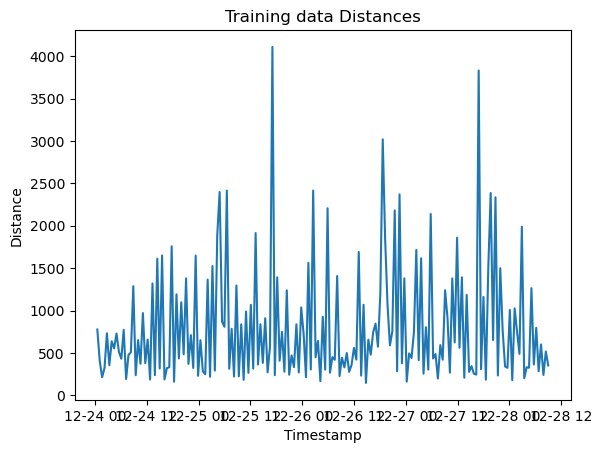

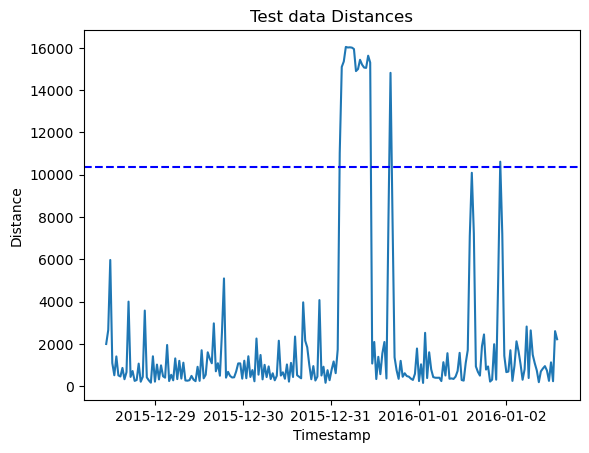

In [7]:
plt.plot(median_train_timestamps,train_distances)
plt.xlabel('Timestamp')
plt.ylabel('Distance')
plt.title('Training data Distances')
plt.show()

mean_test_distances = np.mean(test_distances)
std_dev_test_distances = np.std(test_distances)
dtw_threshold = mean_test_distances + 2 * std_dev_test_distances
plt.plot(median_test_timestamps,test_distances)
plt.axhline(y=dtw_threshold, xmin=0, xmax=20, color='blue', linestyle='dashed')
plt.xlabel('Timestamp')
plt.ylabel('Distance')
plt.title('Test data Distances')
plt.show()

We draw a blue dashed line as the threshold line. The threshold is 2 standard deviations above the mean DTW distance. We consider the data points exceed this line as anomalies.

I expect to detect long-term anomalies using DTW distances. And this plot shows my expectation is correct, as you can see the anomalies' distances rise up and drop down in periods of time, since multiple consecutive windows captured the anomalies.

### Subset choice
I chose a subset of the data points, from 2015-12-24 till the end, because I found at the beginning of the dataset, for some features the periodical pattern had not started to show yet, then later when I used clustering to find similar representative windows I will get a big proportion of representative windows from the start since they are not similar to any others after the beginning part. 
### Window Size
I set the window size to 4000, around 1% of my truncated training data points
After trying a few values of window size out, I found bigger window sizes take me really long time to compute the distances, especially using weblab DTW, Bigger window sizes can capture longer-term patterns but they also might overlook some small short-term anomalies.
### Step Size
I set the step size to 2000, it is 50% of my window size. 
If we set step size smaller then we are sampling more windows, this will lead to more sensitivity to anomalies but the performance can be really poor, takes really long time to compute. 
### Representative windows selection
I applied hierachical clustering in order to select representative windows, so that i can have windows with different patterns. I clustered them into 20% of the number of training data windows clusters and chose the windows from each of the clusters with median indices as their representatives. Sampling too many representative windows can be computationally expensive, however sampling not enough representative windows can also cause big distances between train data sliding windows to these representative windows, making the real anomalies more difficult to spot.


# PCA-based anomaly detection

In [8]:
def principal_component_analysis(df, k):
    eigenvectors = np.zeros(shape=(df.shape[1], k))

    # START ANSWER
    column_means = df.mean(axis=0)
    centered_data = df - column_means
    covariance_matrix = np.cov(centered_data, rowvar = False)
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    top_k_indices = sorted_indices[:k]
    eigenvectors = eigenvectors[:,top_k_indices]
    # END ANSWER

    return eigenvectors
    

def apply_principal_component_analysis(df, eigenvectors):
    projected_data = np.zeros(shape=(df.shape[0], eigenvectors.shape[1]))

    # START ANSWER
    column_means = df.mean(axis=0)
    centered_data = df - column_means
    projected_data = centered_data @ eigenvectors
    # END ANSWER

    return pd.DataFrame(projected_data)

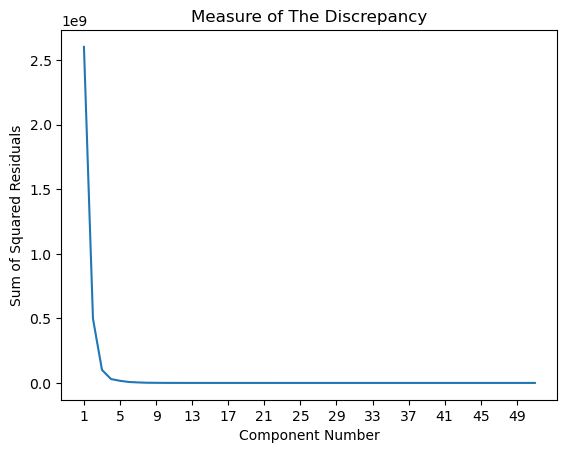

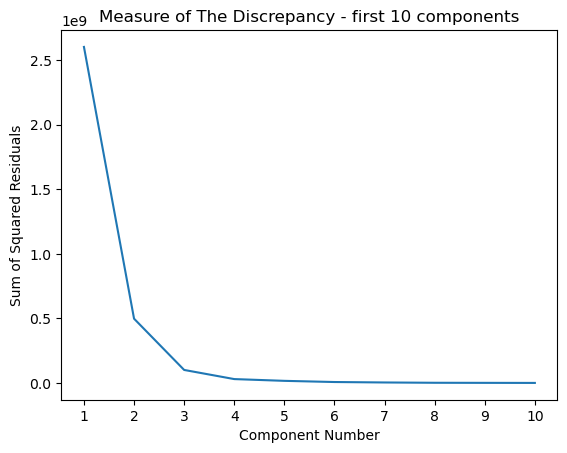

In [9]:
truncated_train_data = train_data[train_data['Timestamp']>'2015-12-24']

usable_train_data = truncated_train_data.drop(columns=['Timestamp', 'Normal/Attack'])
usable_train_data_timestamps = truncated_train_data['Timestamp']
usable_test_data = test_data.drop(columns=['Timestamp', 'Normal/Attack']) 
usable_test_data_timestamps = test_data['Timestamp']

mean_train_data = np.mean(usable_train_data,axis=0)
mean_test_data = np.mean(usable_test_data,axis=0)
list_of_sum_of_squared_residuals = []
for i in range(1,usable_train_data.shape[1]+1):
    eigen = principal_component_analysis(usable_train_data, i)
    pca_train_data = apply_principal_component_analysis(usable_train_data, eigen)
    reconstructed_train_data = (pca_train_data @ eigen.T) + mean_train_data.to_numpy()
    abs_train_residuals = np.linalg.norm(usable_train_data.to_numpy()-reconstructed_train_data,axis=1)
    residual_sum_of_squares = np.sum(abs_train_residuals ** 2)
    list_of_sum_of_squared_residuals.append(residual_sum_of_squares)

plt.plot(list_of_sum_of_squared_residuals)
plt.xticks(np.arange(0,usable_train_data.shape[1],4),np.arange(1, usable_train_data.shape[1]+1,4)) 
plt.xlabel('Component Number')
plt.ylabel('Sum of Squared Residuals')
plt.title('Measure of The Discrepancy')
plt.show()

plt.plot(list_of_sum_of_squared_residuals[:10])
plt.xticks(np.arange(0,10,1),np.arange(1, 11, 1)) 
plt.xlabel('Component Number')
plt.ylabel('Sum of Squared Residuals')
plt.title('Measure of The Discrepancy - first 10 components')
plt.show()
# u can uncomment these to use scree plot to determine number of eigenvectors if u want, this is another option
# centered_train_data = usable_train_data - mean_train_data
# cov_mat = np.cov(centered_train_data, rowvar = False)
# all_eigenvalues, all_eigenvectors = np.linalg.eig(cov_mat)
# sorted_eigenvalues = sorted(all_eigenvalues, reverse=True)

# plt.plot(sorted_eigenvalues[:10])
# plt.xticks(np.arange(0,10,1),np.arange(1, 11, 1)) 
# plt.xlabel('Component Number')
# plt.ylabel('eigenvalue')
# plt.title('Scree Plot - first 10 components')
# plt.show()



We can see the elbow in this plot above is at component 3, but let us take 5 components for less information loss and a reasonable number of false alarms . 
By observing the plot, the components after the 5th really do not show big differences in their eigenvalues. 

In [10]:

k = 5
eigen = principal_component_analysis(usable_train_data, k)

pca_train_data = apply_principal_component_analysis(usable_train_data, eigen)
pca_test_data = apply_principal_component_analysis(usable_test_data, eigen)

reconstructed_train_data = (pca_train_data @ eigen.T) + mean_train_data.to_numpy()
reconstructed_test_data = (pca_test_data @ eigen.T) + mean_test_data.to_numpy()

abs_train_residuals = np.linalg.norm(usable_train_data.to_numpy()-reconstructed_train_data,axis=1)


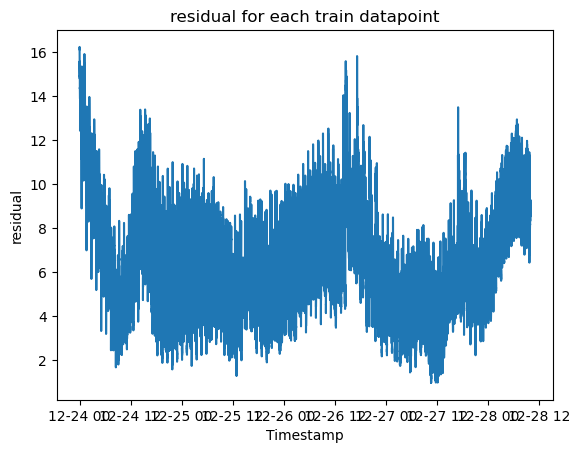

In [11]:
plt.plot(usable_train_data_timestamps, abs_train_residuals)
plt.xlabel('Timestamp')
plt.ylabel('residual')
plt.title('residual for each train datapoint')
plt.show()


From this plot above we can already have some intuitions about the normal datapoints' residuals, now we are going to set a tolerance for our anomalies detection.

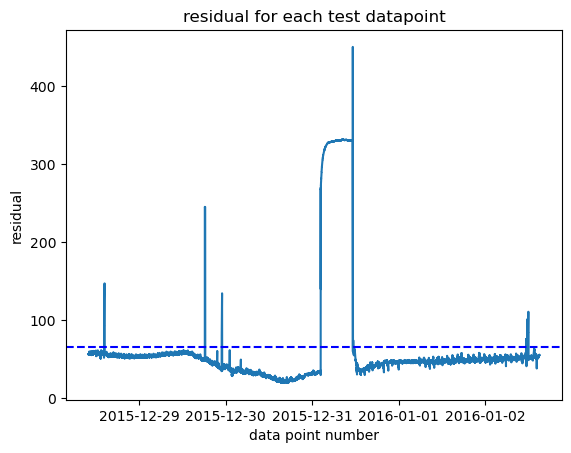

In [12]:
abs_test_residuals = np.linalg.norm(usable_test_data.to_numpy()-reconstructed_test_data,axis=1)
mean_abs_residuals = np.mean(abs_test_residuals)
std_dev_abs_residuals = np.std(abs_test_residuals)
sample_size = len(abs_test_residuals)
# Calculate the Z-score for a one-tailed 99% confidence level
z_score_one_tailed = 2.33 #we can find this from Y1Q4 statistics material
std_error = std_dev_abs_residuals / np.sqrt(sample_size)
# Calculate the upper bound of the one-tailed 99% CI
threshold = mean_abs_residuals + (z_score_one_tailed * std_error)
plt.plot(usable_test_data_timestamps, abs_test_residuals)
plt.axhline(y=threshold, xmin=0, xmax=20, color='blue', linestyle='dashed') 
plt.xlabel('data point number')
plt.ylabel('residual')
plt.title('residual for each test datapoint')

plt.show()

We draw a blue dashed line as the threshold line. The threshold is the 99% confidence interval. We consider the points that exceed this threshold as anomalies.

The occurrence of large abnormalities is caused by dimensionality reduction and reconstruction. Applying PCA to the training data and choosing a proper number of components can reduce correlated features, after this we reconstruct the reduced data and calculate the residual. If the data points are normal, the residuals will not be big (relatively) due to feature correlation. However, if data points are anomalies, the residuals will be abnormal because the features are considered correlated and reduced but this is actually not the case.

I expect to detect short-term anomalies since we are comparing the distances between pairwise data points instead of windows. And this plot shows my expectation is correct, as you can see the anomalies' residuals instantly rise up.

Choosing the number of components has a trade-off. When we choose too little number of components, the number of false alarms gets really big. This is because we lose too much information after the dimensionality reduction and reconstruction, normal data points can also have large residual values. When we choose too large number of components, the dimensions are not reduced enough, so the residuals will not be easily noticed after reconstruction. 